In [1]:
import numpy as np
import pandas as pd
import random
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

from federated_utils import *

In [2]:
#declear path to your data
derbin_data_path = '/home/gp/Desktop/ayushi-malware/data/drebin215.csv'
malgenome_data_path = '/home/gp/Desktop/ayushi-malware/data/malgenome215.csv'


In [33]:
derbin_data = pd.read_csv(derbin_data_path, header = None)
malgenome_data = pd.read_csv(malgenome_data_path)

use_data  = derbin_data

In [34]:
use_data

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,S
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,S
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,S
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,S
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15031,1,1,1,1,1,1,0,1,1,1,...,0,0,0,1,1,0,0,0,0,B
15032,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,B
15033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,B
15034,1,1,1,1,1,1,0,1,1,1,...,1,0,0,1,1,1,0,0,0,B


In [35]:
X = np.array(use_data.iloc[:,range(0,215)]) #feature set
labels = use_data.iloc[:,-1] #labels --> B : Benign and S

In [36]:
#binarize the labels
lb = LabelBinarizer()
y = lb.fit_transform(labels)

In [37]:
#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=100)

In [38]:
number_of_clients = 5
comms_round = 10

In [39]:
#create clients -- Horizontal FL
clients = create_clients(X_train, y_train, num_clients=number_of_clients, initial='client')

#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)

In [40]:
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [41]:
#==============================================
# Traditional FedAvg 2017
#==============================================
#-----------------------------------------------


all_results=list()

#create optimizer
lr = 0.01 
loss='binary_crossentropy'
metrics = ['accuracy']
optimizer = SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )

#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(X.shape[1],1)
#-----------------------------------------------


print('|=======================|')
print('|Traditional FedAvg 2017|')
print('|=======================|')

#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(X.shape[1],1)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=32, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        all_results.append([global_acc,global_loss.numpy()])
        

|=======================|
|Traditional FedAvg 2017|
|=======================|
comm_round: 0 | global_acc: 97.374% | global_loss: 0.5738880634307861
comm_round: 1 | global_acc: 97.540% | global_loss: 0.5709268450737
comm_round: 2 | global_acc: 97.773% | global_loss: 0.5699894428253174
comm_round: 3 | global_acc: 97.872% | global_loss: 0.5693473219871521
comm_round: 4 | global_acc: 97.939% | global_loss: 0.5689835548400879
comm_round: 5 | global_acc: 97.906% | global_loss: 0.568737268447876
comm_round: 6 | global_acc: 98.005% | global_loss: 0.5685167908668518
comm_round: 7 | global_acc: 98.005% | global_loss: 0.5684025287628174
comm_round: 8 | global_acc: 97.972% | global_loss: 0.568207859992981
comm_round: 9 | global_acc: 97.972% | global_loss: 0.5681140422821045


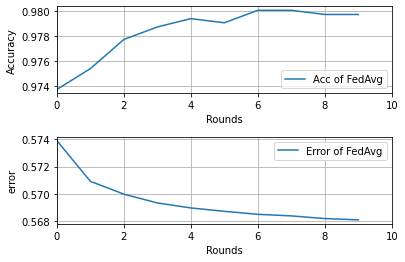

In [42]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

s1 = np.array(all_results) #FedAvg

t = range(0,s1.shape[0])

ax1.plot(t, s1[:,0],label='Acc of FedAvg')
ax1.set_xlim(0,s1.shape[0])
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Accuracy')
ax1.grid(True)
ax1.legend()


ax2.plot(t, s1[:,1],label='Error of FedAvg')
ax2.set_xlim(0, s1.shape[0])
ax2.set_xlabel('Rounds')
ax2.set_ylabel('error')
ax2.grid(True)
ax2.legend()

plt.show()



In [26]:
s1.shape

(10, 2)